# Theory and Toy Problems

In [53]:
import graph_structure as gs
import numpy as np
from tqdm import tqdm
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import scipy.stats as st

# Adding white noise

In [243]:
n_samples = 100
dim = 50
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, n_samples))

In [245]:
def alpha_from_snr(snr):
    return 10**(-snr / 20)

def make_curves(seed, n_samples, dim, snrs, ks):    
    np.random.seed(seed)
    x = np.random.randn(n_samples, dim)
    nx = gs.nearest_neighbors(x)
    curves = []
    for snr in snrs:
        alpha = alpha_from_snr(snr)
        y = x + alpha * (np.random.randn(n_samples, dim))
        ny = gs.nearest_neighbors(y)
        res = []
        for k in ks:
            if k == 0:
                res.append(0)
                continue
            res.append(gs.mean_neighborhood_similarity_from_neighborhood(nx, ny, k))
        curves.append(res)

    return np.array(curves)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  48 | elapsed:  4.0min remaining: 60.4min
[Parallel(n_jobs=-1)]: Done   8 out of  48 | elapsed:  4.0min remaining: 20.2min
[Parallel(n_jobs=-1)]: Done  13 out of  48 | elapsed:  4.0min remaining: 10.9min
[Parallel(n_jobs=-1)]: Done  18 out of  48 | elapsed:  4.1min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done  23 out of  48 | elapsed:  4.1min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done  28 out of  48 | elapsed:  4.1min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  33 out of  48 | elapsed:  4.2min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:  4.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:  4.2min remaining:   29.1s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  4.2min finished


In [237]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_distances

snrs = [8,9,10,10.5,11,12] 
dim = 50
n_samples = 1000
x = np.random.randn(n_samples, dim)

for snr in snrs:
    alpha = alpha_from_snr(snr)
    y = x + alpha*np.random.randn(n_samples, dim)
    # plt.figure()
    displacement = np.diag(pairwise_distances(x,y, metric='cosine'))
    # plt.hist(displacement.reshape( (-1,1)), bins=20)
    # plt.title(str(snr))
    # plt.show()
    D = pairwise_distances(x,x, metric='cosine')
    np.fill_diagonal(D, np.inf)
    closest = np.sort(D, axis=1)[:,0]
    closest1 = np.sort(D, axis=1)[:,1]
    dx = closest1-closest
    dx.reshape( (-1,1))
    dx = dx[dx!=0]
    print(snr, displacement.mean(), dx.mean(), dx.std(),  dx.std()/dx.mean(), dx.min(), dx.max())


8 0.07228382287503322 0.03394191835852456 0.031612607846222406 0.9313736339915171 1.5216877843227117e-05 0.18745893790967494
9 0.058580491293710124 0.03394191835852456 0.031612607846222406 0.9313736339915171 1.5216877843227117e-05 0.18745893790967494
10 0.04760390561792876 0.03394191835852456 0.031612607846222406 0.9313736339915171 1.5216877843227117e-05 0.18745893790967494
10.5 0.042616338719150465 0.03394191835852456 0.031612607846222406 0.9313736339915171 1.5216877843227117e-05 0.18745893790967494
11 0.038411014172152196 0.03394191835852456 0.031612607846222406 0.9313736339915171 1.5216877843227117e-05 0.18745893790967494
12 0.030730544945159494 0.03394191835852456 0.031612607846222406 0.9313736339915171 1.5216877843227117e-05 0.18745893790967494


(array([ 8., 13., 23., 20., 19.,  6.,  4.,  3.,  2.,  2.]),
 array([2.40235848e-05, 3.20220196e-05, 4.00204545e-05, 4.80188893e-05,
        5.60173242e-05, 6.40157590e-05, 7.20141939e-05, 8.00126287e-05,
        8.80110636e-05, 9.60094984e-05, 1.04007933e-04]),
 <BarContainer object of 10 artists>)

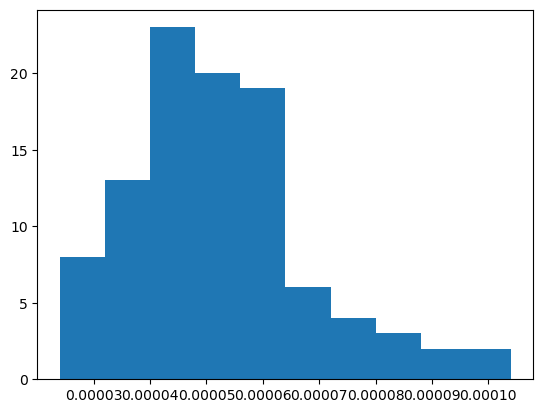

In [228]:
plt.hist(displacement.reshape( (-1,1)))

In [248]:
n_samples = 100
dim = 50
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, n_samples))
all_curves = Parallel(n_jobs=-1, verbose=10)(delayed(make_curves)(n, n_samples, dim, snrs, ks)
                                             for n in range(48))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  48 | elapsed:    1.6s remaining:   23.9s
[Parallel(n_jobs=-1)]: Done   8 out of  48 | elapsed:    2.0s remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  13 out of  48 | elapsed:    2.2s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  18 out of  48 | elapsed:    2.2s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  23 out of  48 | elapsed:    2.2s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  28 out of  48 | elapsed:    2.2s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  33 out of  48 | elapsed:    2.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:    2.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:    2.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    2.6s finished


In [249]:
# Hypergeometric
# M = number of possibilities
# N = number of possibilities of victory
# n = number of trials
M = n_samples-1
n = ks[:-2]
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

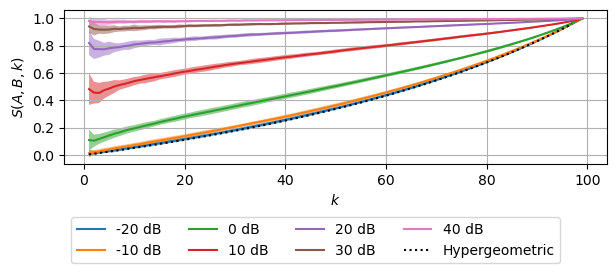

In [251]:

all_curves_ = np.array(all_curves)
curves = np.mean(all_curves_, axis=0)
errors = np.std(all_curves_, axis=0)*2

curves.shape
labels = [f'{s} dB' for s in snrs]

plt.figure(figsize=(7, 2))

for c in range(curves.shape[0]):
    plt.plot(ks, curves[c,:], label=labels[c])
    plt.fill_between(ks, curves[c,:]+errors[c,:], curves[c,:]-errors[c,:], alpha=0.5)

plt.plot(n, js, 'k:', label='Hypergeometric')

plt.xlabel('$k$')
plt.ylabel('$S(A,B,k)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.savefig('sabk_white_noise_100.pdf', bbox_inches='tight')
plt.show()

In [252]:
n_samples = 200
dim = 50
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, n_samples))
all_curves = Parallel(n_jobs=-1, verbose=10)(delayed(make_curves)(n, n_samples, dim, snrs, ks)
                                             for n in range(48))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  48 | elapsed:   15.6s remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   8 out of  48 | elapsed:   15.7s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  13 out of  48 | elapsed:   15.7s remaining:   42.3s
[Parallel(n_jobs=-1)]: Done  18 out of  48 | elapsed:   15.8s remaining:   26.4s
[Parallel(n_jobs=-1)]: Done  23 out of  48 | elapsed:   16.0s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done  28 out of  48 | elapsed:   16.2s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  33 out of  48 | elapsed:   16.3s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:   16.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:   16.4s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   16.6s finished


In [253]:
# Hypergeometric
# M = number of possibilities
# N = number of possibilities of victory
# n = number of trials
M = n_samples-1
n = ks[:-2]
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

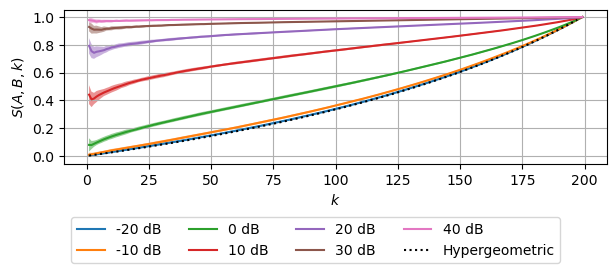

In [254]:
# Hypergeometric
# M = number of possibilities
# N = number of possibilities of victory
# n = number of trials
M = n_samples-1
n = ks[:-2]
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

all_curves_ = np.array(all_curves)
curves = np.mean(all_curves_, axis=0)
errors = np.std(all_curves_, axis=0)*2

curves.shape
labels = [f'{s} dB' for s in snrs]

plt.figure(figsize=(7, 2))

for c in range(curves.shape[0]):
    plt.plot(ks, curves[c,:], label=labels[c])
    plt.fill_between(ks, curves[c,:]+errors[c,:], curves[c,:]-errors[c,:], alpha=0.5)

plt.plot(n, js, 'k:', label='Hypergeometric')

plt.xlabel('$k$')
plt.ylabel('$S(A,B,k)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.savefig('sabk_white_noise_200.pdf', bbox_inches='tight')
plt.show()

In [259]:
n_samples = 200
dim = 150
snrs = [-20, -10, 0, 10, 20, 30, 40] # dB
ks = list(range(1, n_samples))
all_curves = Parallel(n_jobs=-1, verbose=10)(delayed(make_curves)(n, n_samples, dim, snrs, ks)
                                             for n in range(48))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  48 | elapsed:   15.6s remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   8 out of  48 | elapsed:   15.6s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  13 out of  48 | elapsed:   15.7s remaining:   42.2s
[Parallel(n_jobs=-1)]: Done  18 out of  48 | elapsed:   15.7s remaining:   26.2s
[Parallel(n_jobs=-1)]: Done  23 out of  48 | elapsed:   16.0s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done  28 out of  48 | elapsed:   16.3s remaining:   11.7s
[Parallel(n_jobs=-1)]: Done  33 out of  48 | elapsed:   16.4s remaining:    7.5s
[Parallel(n_jobs=-1)]: Done  38 out of  48 | elapsed:   16.5s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  43 out of  48 | elapsed:   16.6s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   16.9s finished


In [260]:
# Hypergeometric
# M = number of possibilities
# N = number of possibilities of victory
# n = number of trials
M = n_samples-1
n = ks[:-2]
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

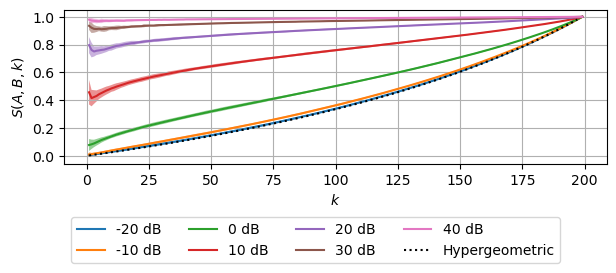

In [261]:
# Hypergeometric
# M = number of possibilities
# N = number of possibilities of victory
# n = number of trials
M = n_samples-1
n = ks[:-2]
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

all_curves_ = np.array(all_curves)
curves = np.mean(all_curves_, axis=0)
errors = np.std(all_curves_, axis=0)*2

curves.shape
labels = [f'{s} dB' for s in snrs]

plt.figure(figsize=(7, 2))

for c in range(curves.shape[0]):
    plt.plot(ks, curves[c,:], label=labels[c])
    plt.fill_between(ks, curves[c,:]+errors[c,:], curves[c,:]-errors[c,:], alpha=0.5)

plt.plot(n, js, 'k:', label='Hypergeometric')

plt.xlabel('$k$')
plt.ylabel('$S(A,B,k)$')
a = 0.2
plt.yticks(np.arange(0, 1 + a, a))
#plt.semilogx()
plt.grid()
plt.legend(ncols=4, loc='upper left', bbox_to_anchor=(0.0, -0.3))
plt.savefig('sabk_white_noise_200_dim_150.pdf', bbox_inches='tight')
plt.show()

Se colocamos muitos pontos na mesma região, então qualquer ruído fica muito mais impactante!

# 

0.5011872336272722